In [4]:
import sklearn
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import tree

%matplotlib inline

# Explore the Transactions

In [5]:
# import revised transactions csv file
transactions = pd.read_csv('transactions.csv')
transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-04
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-05
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-22
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-18
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-12


In [6]:
# information about transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
transaction_id             20000 non-null int64
product_id                 20000 non-null int64
customer_id                20000 non-null int64
transaction_date           20000 non-null object
online_order               19640 non-null float64
order_status               20000 non-null object
brand                      19803 non-null object
product_line               19803 non-null object
product_class              19803 non-null object
product_size               19803 non-null object
list_price                 20000 non-null float64
standard_cost              19803 non-null float64
product_first_sold_date    19803 non-null object
dtypes: float64(3), int64(3), object(7)
memory usage: 2.0+ MB


In [7]:
# convert the columns with date to datetime datatype
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['product_first_sold_date'] = pd.to_datetime(transactions['product_first_sold_date'])
transactions.dtypes

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date    datetime64[ns]
dtype: object

Text(0, 0.5, 'Counts')

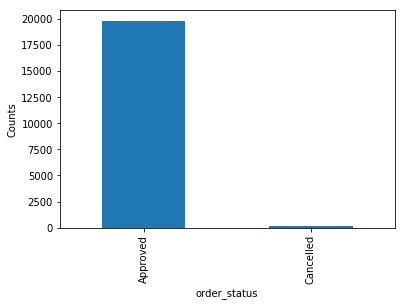

In [5]:
# explore the distribution of the order_status
transactions.order_status.value_counts().plot(kind='bar')
plt.xlabel('order_status')
plt.ylabel('Counts')

Since the number of canceled order is much smaller than the approved ones, and we would like to find more detail information about approved orders which may help the business strategies of clients. 

In [6]:
# define a function to plot the bar plot of each variable of approved orders
def countplot(df,variable_name):   
    ax = df[df.order_status == 'Approved'].groupby(variable_name).count()['transaction_id'].plot(kind='bar')
    # annotate bars with values
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.xlabel(variable_name)
    plt.ylabel('Counts');
    return

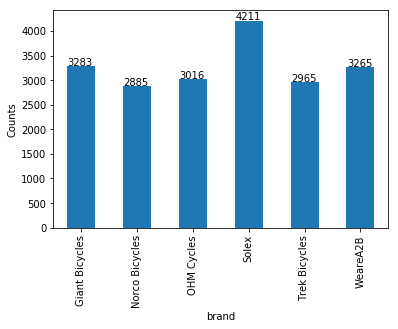

In [7]:
# explore the most popular brand in approved orders
countplot(transactions, 'brand')

The most popular brand of approved orders is Solex.

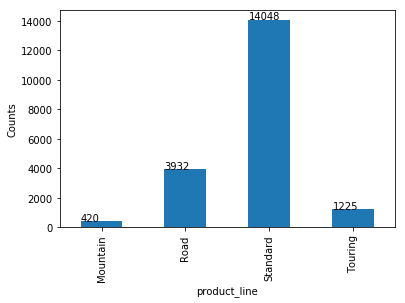

In [8]:
# explore the most popular brand in approved orders
countplot(transactions, 'product_line')

Standard is most popular product line. Then are the road, touring and mountain.

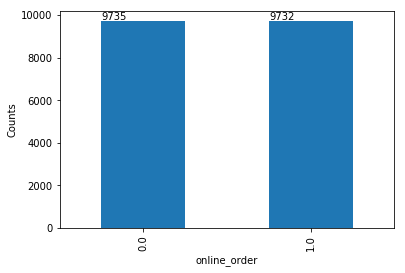

In [9]:
# explore the online orders in approved orders
countplot(transactions, 'online_order')

In [9]:
# add profit column to transaction
transactions['profit'] = transactions['list_price'] - transactions['standard_cost']

Text(0, 0.5, 'Counts')

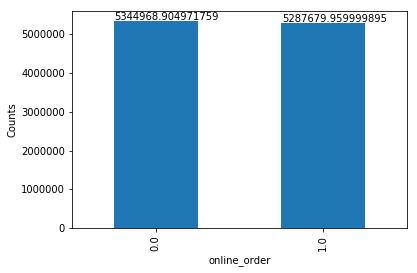

In [11]:
# the relationship of profit and platform of approved orders
ax = transactions.query('order_status == "Approved"').groupby('online_order').sum()['profit'].sort_values(ascending=False).plot(kind='bar')
# annotate bars with values
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.ylabel('Counts')

There are not much difference between ordering platfroms(whether it is online ordering or offline ordering) in order numbers and profit. 

Text(0, 0.5, 'Counts')

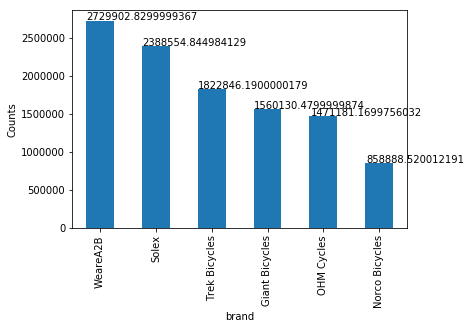

In [12]:
# high profit brand
ax = transactions.query('order_status == "Approved"').groupby('brand').sum()['profit'].sort_values(ascending=False).plot(kind='bar')
# annotate bars with values
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.ylabel('Counts')

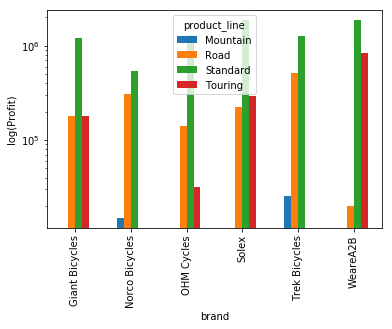

In [13]:
# high profit product line in each brand
# https://stackoverflow.com/questions/34248741/plotting-pandas-multiindex-bar-chart
# add logarithm to x axis
# https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.plot.html
transactions.query('order_status == "Approved"').groupby(['brand', 'product_line']).profit.sum().unstack().plot(kind='bar', logy=True)
plt.ylabel('log(Profit)');

Standard line is most profitable among all the brands. However, the touring line is also important in the most profitable brand WeareA2B. The most progitable road line is in Trek Bicycles.

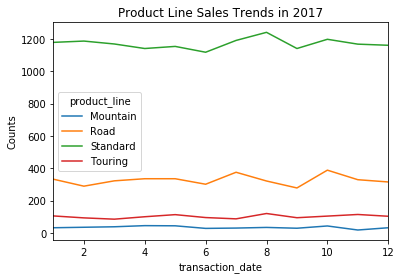

In [14]:
# product line vs. month in approved orders
transactions.query('order_status == "Approved"').groupby([transactions['transaction_date'].dt.month, 'product_line']).count()['transaction_id'].unstack().plot(kind='line')
plt.ylabel('Counts')
plt.title('Product Line Sales Trends in 2017');

There are pretty stable trends of different product line in each month of 2017. For standard line, the transaction amounts in August and October were slightly higher than other months. For road line, the transaction amounts in July and October were slightly higher than other months.

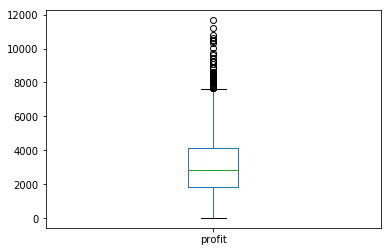

In [15]:
# overall profit from each customer in 2017
transactions.query('order_status == "Approved"').groupby('customer_id').profit.sum().plot.box()

In [10]:
transactions.query('order_status == "Approved"').groupby('customer_id').profit.sum().describe()

count     3493.000000
mean      3100.917273
std       1764.116177
min         15.080000
25%       1828.470000
50%       2840.810000
75%       4150.060000
max      11668.950000
Name: profit, dtype: float64

According to the box plot of customer profit distribution, we would like to set the third quartile (4150) of it as the threshold of high values customer for clients.

In [11]:
# filter out the customer id of high value customer
profit_per_customer = transactions.query('order_status == "Approved"').groupby('customer_id').profit.sum()
high_value_customer = profit_per_customer[profit_per_customer >= 4150]
high_value_customer.index

Int64Index([   8,   13,   16,   21,   22,   23,   25,   29,   33,   34,
            ...
            3461, 3462, 3465, 3467, 3470, 3477, 3478, 3482, 3484, 3499],
           dtype='int64', name='customer_id', length=874)

In [15]:
# set for fasting searching
high_value_customer_id = set(high_value_customer.index.tolist())
high_value_customer_id

{8,
 13,
 16,
 21,
 22,
 23,
 25,
 29,
 33,
 34,
 37,
 39,
 40,
 41,
 44,
 47,
 48,
 49,
 50,
 51,
 52,
 57,
 61,
 62,
 65,
 69,
 75,
 80,
 89,
 91,
 94,
 97,
 99,
 109,
 112,
 117,
 119,
 131,
 139,
 144,
 147,
 151,
 153,
 158,
 165,
 166,
 167,
 168,
 171,
 173,
 174,
 182,
 189,
 195,
 198,
 200,
 201,
 204,
 213,
 220,
 223,
 230,
 234,
 235,
 239,
 247,
 254,
 255,
 270,
 273,
 280,
 283,
 294,
 295,
 298,
 299,
 310,
 312,
 320,
 322,
 325,
 330,
 331,
 339,
 344,
 346,
 347,
 352,
 353,
 357,
 360,
 363,
 365,
 371,
 374,
 377,
 380,
 381,
 385,
 392,
 394,
 395,
 396,
 399,
 402,
 404,
 419,
 425,
 426,
 430,
 432,
 435,
 438,
 445,
 446,
 454,
 461,
 469,
 473,
 482,
 486,
 490,
 498,
 506,
 507,
 509,
 513,
 515,
 516,
 528,
 533,
 534,
 538,
 545,
 546,
 548,
 565,
 569,
 576,
 577,
 579,
 590,
 594,
 599,
 604,
 605,
 607,
 614,
 621,
 627,
 634,
 636,
 637,
 640,
 645,
 647,
 648,
 655,
 665,
 668,
 669,
 671,
 682,
 685,
 691,
 692,
 695,
 700,
 703,
 706,
 710,
 712,
 7

# Explore the customer data

In [12]:
# import revised transactions csv file
customers = pd.read_csv('customer.csv')
customers.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,0 Holy Cross Court,4211,QLD,Australia,9
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9


In [20]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3995 entries, 0 to 3994
Data columns (total 18 columns):
customer_id                            3995 non-null int64
first_name                             3995 non-null object
last_name                              3870 non-null object
gender                                 3995 non-null object
past_3_years_bike_related_purchases    3995 non-null int64
DOB                                    3908 non-null object
job_title                              3491 non-null object
job_industry_category                  3340 non-null object
wealth_segment                         3995 non-null object
deceased_indicator                     3995 non-null object
default                                3694 non-null object
owns_car                               3995 non-null object
tenure                                 3908 non-null float64
address                                3995 non-null object
postcode                               3995 non-null i

In [13]:
# convert the DOB column with date to datetime datatype
customers['DOB'] = pd.to_datetime(customers['DOB'])
customers.dtypes

customer_id                                     int64
first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
default                                        object
owns_car                                       object
tenure                                        float64
address                                        object
postcode                                        int64
state                                          object
country                                        object
property_valuation                              int64
dtype: object

In [22]:
# drop the default and country columns, since they didn't provide any useful information about the customers
customers = customers.drop(['default', 'country'], axis=1)
customers.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state',
       'property_valuation'],
      dtype='object')

In [16]:
# using customer_id of high valued customers from transactions dataframes, filter out the high valued customers 
high_value_customers = customers[customers['customer_id'].isin(high_value_customer_id)]
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 6 to 3493
Data columns (total 18 columns):
customer_id                            871 non-null int64
first_name                             871 non-null object
last_name                              847 non-null object
gender                                 871 non-null object
past_3_years_bike_related_purchases    871 non-null int64
DOB                                    843 non-null datetime64[ns]
job_title                              772 non-null object
job_industry_category                  729 non-null object
wealth_segment                         871 non-null object
deceased_indicator                     871 non-null object
default                                806 non-null object
owns_car                               871 non-null object
tenure                                 843 non-null float64
address                                871 non-null object
postcode                               871 non-null int64
sta

In [17]:
# there are two customers missing in the customer dataframe, we would like to seek out them
missing_customer_id = high_value_customer_id - set(high_value_customers.customer_id.tolist())
missing_customer_id

{22, 23, 34}

When we filtering out the high valued customers in customer dataframe using the high valued customer ids of transactions, there are 2 customers' information are not in the customer dataframe(customer_id 22 ,23 and 34). Especially, 34 is the person who has wrong birth year(1834).

In [25]:
# explore the gender condition of the high valued customers
# create a function of bar plot displaying single categorical variable 
def cat_barplot(df,variable_name):   
    ax = df.groupby(variable_name).count()['customer_id'].plot(kind='bar')
    # annotate bars with values
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.xlabel(variable_name)
    plt.ylabel('Counts');
    return

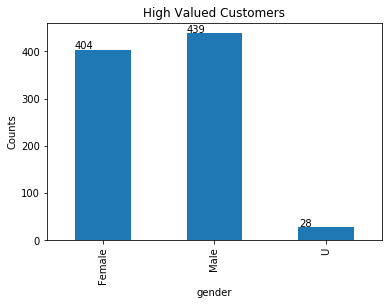

In [26]:
cat_barplot(high_value_customers, 'gender')
plt.title('High Valued Customers');

There are not much difference between different gender in high valued customers.

In [18]:
# define a function to calculate the age by using DOB
# https://moonbooks.org/Articles/How-to-get-the-age-from-a-date-of-birth-DOB-in-python-/
def from_dob_to_age(born):
    today = dt.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [19]:
high_value_customers['age'] = high_value_customers['DOB'].apply(lambda x: from_dob_to_age(x))
high_value_customers.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation,age
6,8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,(â¯Â°â¡Â°ï¼â¯ï¸µ â»ââ»),No,7.0,49 Londonderry Lane,2650,NSW,Australia,4,58.0
10,13,Gabriele,Norcross,Male,38,1955-02-15,Developer I,Financial Services,High Net Worth,N,-100,Yes,8.0,2 Sutherland Street,3799,VIC,Australia,6,65.0
13,16,Harlin,Parr,Male,38,1977-02-27,Media Manager IV,NaN,Mass Customer,N,1000000000000000049861653971908893017010268485...,Yes,18.0,52 Moland Street,3331,VIC,Australia,4,43.0
18,21,Mile,Cammocke,Male,74,1980-09-20,Safety Technician I,Manufacturing,Affluent Customer,N,-100,Yes,16.0,18 Jenna Center,2650,NSW,Australia,7,40.0
20,25,Geoff,Assaf,Male,72,1976-12-02,Accounting Assistant III,Financial Services,Mass Customer,N,×Ö¸×Ö°×ªÖ¸×testØ§ÙØµÙØ­Ø§Øª Ø§ÙØªÙØ­ÙÙ,Yes,21.0,28 5th Center,4413,QLD,Australia,3,43.0


In [29]:
# statistics of age from high value customer
high_value_customers['age'].dropna().describe()

count    843.000000
mean      42.529063
std       12.548151
min       18.000000
25%       33.000000
50%       42.000000
75%       52.000000
max       88.000000
Name: age, dtype: float64

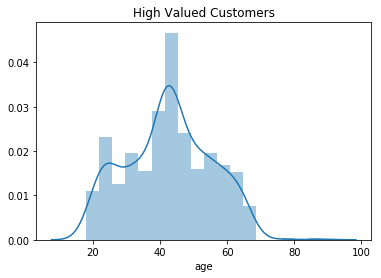

In [30]:
# check the age distribution of high valued customers
sns.distplot(high_value_customers['age'].dropna())
plt.title('High Valued Customers');

Most high valued customers are between 40 and 50 years old.

Text(0.5, 1.0, 'High Valued Customers')

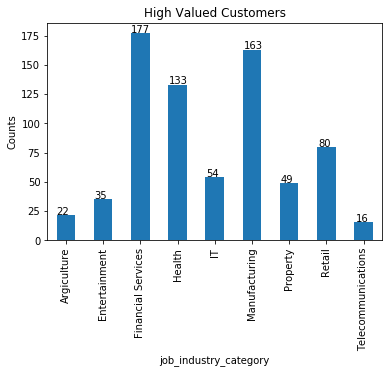

In [31]:
# job_industry_category condition in high valued customers
cat_barplot(high_value_customers, 'job_industry_category')
plt.title('High Valued Customers')

High valued customers more likely to work in financial services, manufacturing and health industry.

Text(0.5, 1.0, 'High Valued Customers')

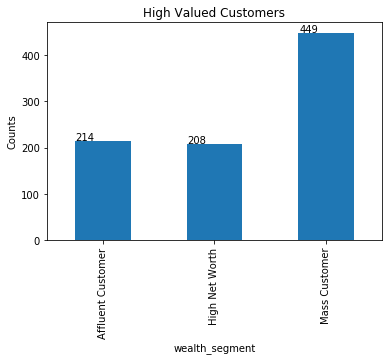

In [32]:
# wealth condition in high valued customers
cat_barplot(high_value_customers, 'wealth_segment')
plt.title('High Valued Customers')

Most high valued customers are mass customer.

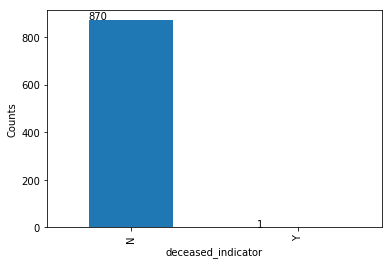

In [33]:
# deceased_indicator condition in high valued customers
cat_barplot(high_value_customers, 'deceased_indicator')

Most high valued customers have no deceased indicator.

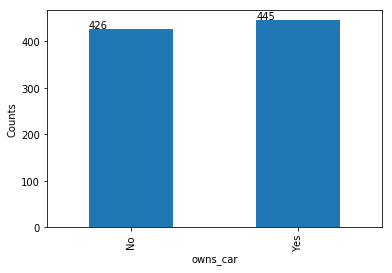

In [34]:
# car condition in high valued customers
cat_barplot(high_value_customers, 'owns_car')

There is not much difference between people who own the car and people without any car.

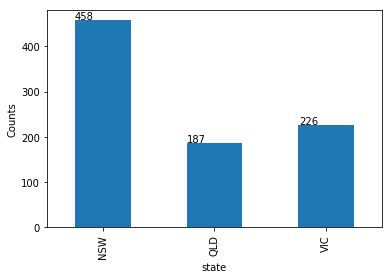

In [35]:
# where are these high valued customers
cat_barplot(high_value_customers, 'state')

Most high valued customers live in New South Wales.

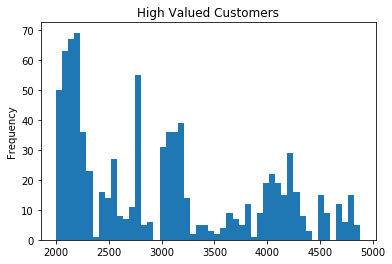

In [36]:
high_value_customers.postcode.plot(kind='hist', bins=50)
plt.title('High Valued Customers');

In [37]:
high_value_customers.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,age
count,871.000000,871.000000,843.000000,871.000000,871.000000,843.000000
mean,1761.716418,50.417910,10.979834,3003.880597,7.447761,42.529063
std,999.714409,28.445388,5.709585,850.109404,2.832361,12.548151
min,8.000000,0.000000,1.000000,2000.000000,1.000000,18.000000
25%,907.500000,27.000000,6.000000,2210.000000,6.000000,33.000000
50%,1793.000000,50.000000,11.000000,2768.000000,8.000000,42.000000
75%,2605.500000,75.000000,16.000000,3756.000000,9.500000,52.000000
max,3499.000000,99.000000,22.000000,4883.000000,12.000000,88.000000


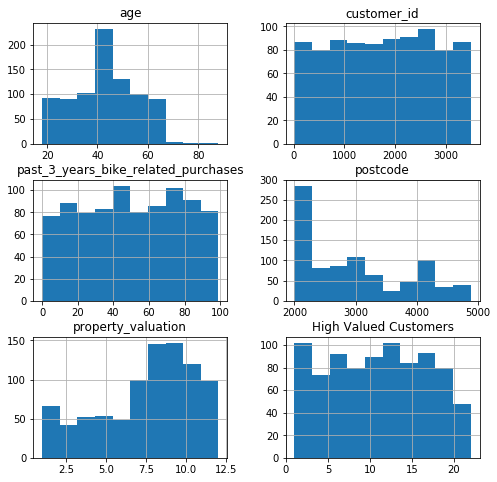

In [38]:
# the distribution of each feature in the high valued customer
high_value_customers.hist(figsize=(8,8))
plt.title('High Valued Customers');

In [20]:
# Bin edges that will be used to "cut" the age into groups
bin_edges = [0,21,31,41,51,61,110]
# Labels for the four popularity groups
bin_names = ['0-20','21-30','31-40','41-50','51-60', '>60']
# Creates popuar levels column
high_value_customers['age_levels'] = pd.cut(high_value_customers['age'], bin_edges, labels=bin_names, right=False)
# Checks for successful creation of this column
high_value_customers.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation,age,age_levels
6,8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,(â¯Â°â¡Â°ï¼â¯ï¸µ â»ââ»),No,7.0,49 Londonderry Lane,2650,NSW,Australia,4,58.0,51-60
10,13,Gabriele,Norcross,Male,38,1955-02-15,Developer I,Financial Services,High Net Worth,N,-100,Yes,8.0,2 Sutherland Street,3799,VIC,Australia,6,65.0,>60
13,16,Harlin,Parr,Male,38,1977-02-27,Media Manager IV,NaN,Mass Customer,N,1000000000000000049861653971908893017010268485...,Yes,18.0,52 Moland Street,3331,VIC,Australia,4,43.0,41-50
18,21,Mile,Cammocke,Male,74,1980-09-20,Safety Technician I,Manufacturing,Affluent Customer,N,-100,Yes,16.0,18 Jenna Center,2650,NSW,Australia,7,40.0,31-40
20,25,Geoff,Assaf,Male,72,1976-12-02,Accounting Assistant III,Financial Services,Mass Customer,N,×Ö¸×Ö°×ªÖ¸×testØ§ÙØµÙØ­Ø§Øª Ø§ÙØªÙØ­ÙÙ,Yes,21.0,28 5th Center,4413,QLD,Australia,3,43.0,41-50


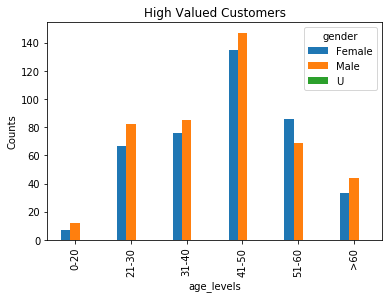

In [40]:
# Find the gender condition in each age level
high_value_customers.groupby(['age_levels','gender']).count()['customer_id'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Counts');

Male customers are more than female ones in different age levels of high valued customers, except for 51-60 years old which has more female than male. 

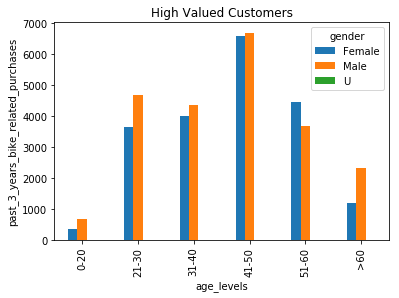

In [41]:
# Find the past_3_years_bike_related_purchases with groupby age level and gender
high_value_customers.groupby(['age_levels','gender']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('past_3_years_bike_related_purchases');

- For high valued customers are in 41-50 years old, male and female purchased equally bike related products in past three years. This age level also purchased most among all age levels;   
- For high valued customers are in 51-60 years old, female purchased more bike related products than male in past three years.It is opposite to the other four age groups;   
- For high valued customers are in 0-20 and over 60 years old, they purchased less bike related products among all age levels.

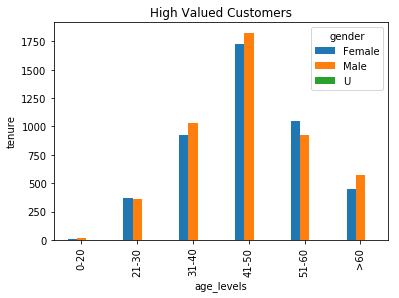

In [42]:
# Find the tenure with groupby age level and gender
high_value_customers.groupby(['age_levels','gender']).sum()['tenure'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('tenure');

- For high valued customers are in 21-30 years old, male and female have approximately same tenure;   
- For high valued customers are in 31-40, 41-50 and over 60 years old, male has longer tenure than female;   
- For high valued customers are in 51-60 years old, female has longer tenure than male.

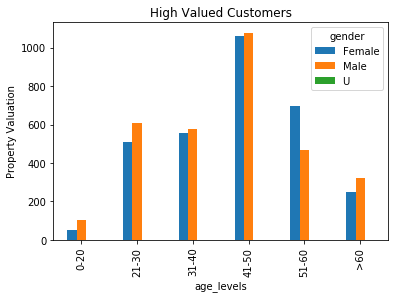

In [43]:
# Find the property_valuation with groupby age level and gender
high_value_customers.groupby(['age_levels','gender']).sum()['property_valuation'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Property Valuation');

- For high valued customers are in 41-50, 31-40 years old, male and female have approximately same property_valuation;   
- For high valued customers are in 0-20, 21-30 and over 60 years old, male has high property_valuation than female;   
- For high valued customers are in 51-60 years old, female has high property_valuation than male.

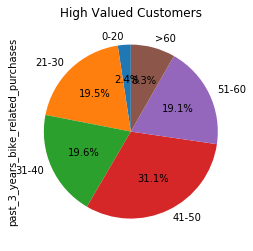

In [44]:
# past_3_years_bike_related_purchases in different age levels
high_value_customers.groupby(['age_levels']).sum()['past_3_years_bike_related_purchases'].plot(kind='pie', subplots=True,startangle=90, autopct='%1.1f%%')
plt.title('High Valued Customers');

High valued customers in 41-50 years old purchased most bike related products among all age levels in the past three year. The next is 31-40 and 21-30 years old. The purchases of all those customer takes 89.4% of purchase amount of high valued customers. 

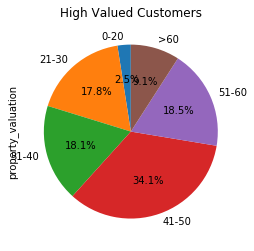

In [45]:
# property valuation in different age levels
high_value_customers.groupby(['age_levels']).sum()['property_valuation'].plot(kind='pie', subplots=True,startangle=90, autopct='%1.1f%%')
plt.title('High Valued Customers');

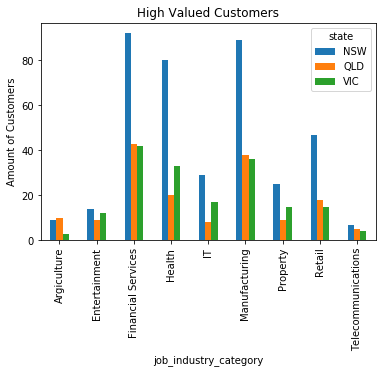

In [46]:
# job_industry_category in each state
high_value_customers.groupby(['job_industry_category','state']).size().unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Amount of Customers');

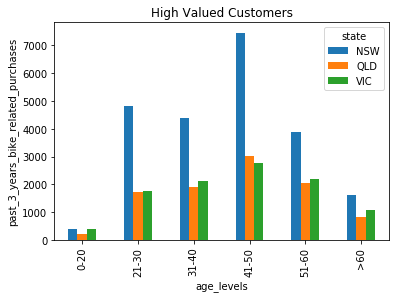

In [47]:
# past_3_years_bike_related_purchases in different age levels and states
high_value_customers.groupby(['age_levels','state']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('past_3_years_bike_related_purchases');

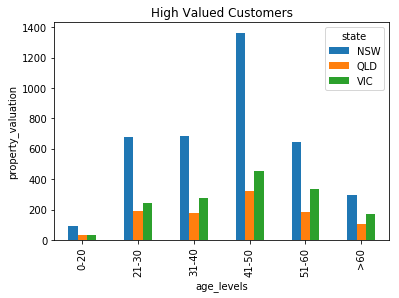

In [48]:
# property_valuation in different age levels and states
high_value_customers.groupby(['age_levels','state']).sum()['property_valuation'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('property_valuation');

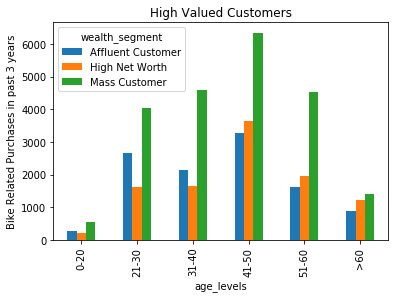

In [49]:
#  purchases condition in different age levels and wealth conditions
high_value_customers.groupby(['age_levels', 'wealth_segment']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Bike Related Purchases in past 3 years');

- For high valued customers are in 41-50, 51-60 and over 60 years old, mass customer did most bike related purchases in the past three years, the next is high net worth;   
- For high valued customers are in 0-20, 21-30 and 31-40 years old, mass customer did most bike related purchases in the past three years, the next is affluent customer.

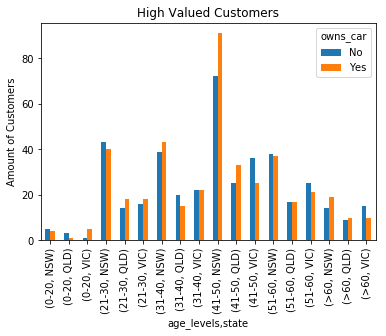

In [50]:
#  car owning condition in different age levels and state
high_value_customers.groupby(['age_levels','state','owns_car']).size().unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Amount of Customers');

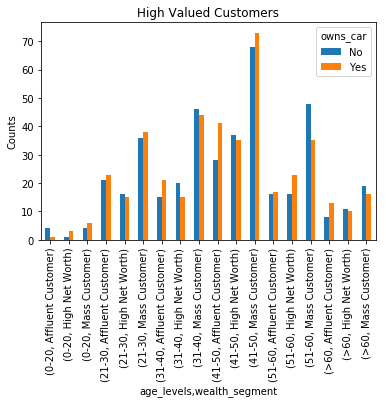

In [51]:
#  car owning condition in different age levels and wealth conditions
high_value_customers.groupby(['age_levels','wealth_segment','owns_car']).size().unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Counts');

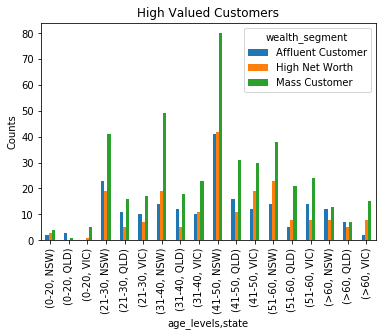

In [52]:
# wealth condition in different age levels and states
high_value_customers.groupby(['age_levels','state', 'wealth_segment']).size().unstack().plot(kind='bar')
plt.title('High Valued Customers')
plt.ylabel('Counts');

Most high valued customers are mass customer, who live in New South Wales and are between 41 and 50 years old. 

In [53]:
# create a new dataframe for correlation map
corr = high_value_customers[['gender', 'past_3_years_bike_related_purchases','wealth_segment', 'owns_car', 'state','property_valuation', 'age_levels']]
corr_dummy = pd.get_dummies(corr.copy())
corr_dummy.head()

,past_3_years_bike_related_purchases,property_valuation,gender_Female,gender_Male,gender_U,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,owns_car_No,owns_car_Yes,state_NSW,state_QLD,state_VIC,age_levels_0-20,age_levels_21-30,age_levels_31-40,age_levels_41-50,age_levels_51-60,age_levels_>60
6,31,4,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0
10,38,6,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
13,38,4,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
18,74,7,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0
20,72,3,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0


Text(158.09375, 0.5, '')

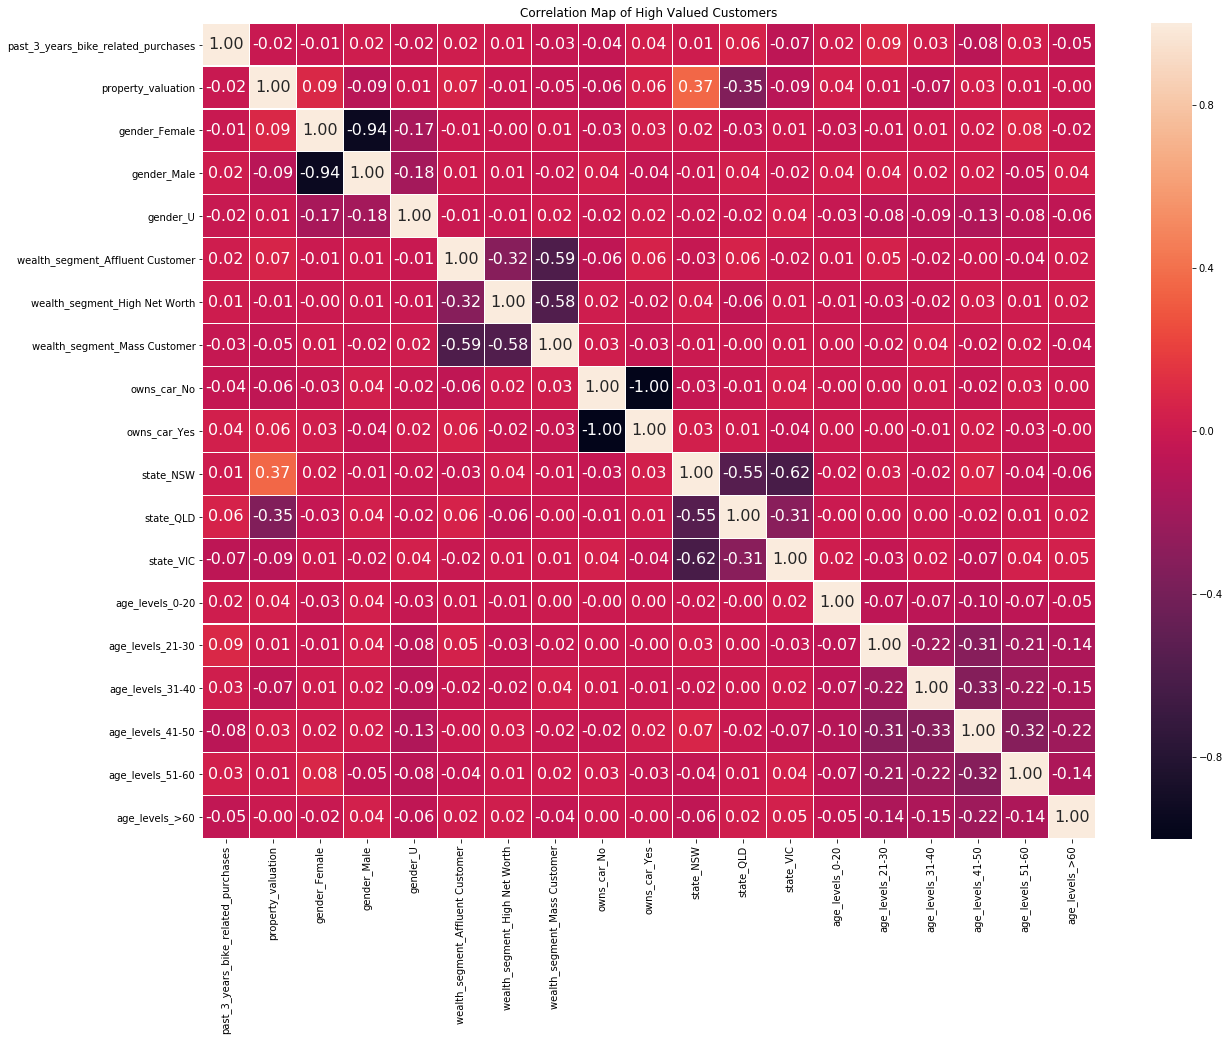

In [54]:
# the correlation map of each variable
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title('Correlation Map of High Valued Customers')

sns.heatmap(corr_dummy.corr(),
            xticklabels=corr_dummy.columns.values,
            yticklabels=corr_dummy.columns.values,
            annot = True,
            annot_kws={"size": 16},
            linewidths=0.2,
            fmt=".2f",);
plt.xlabel('', fontsize = 15) 
plt.ylabel('', fontsize = 15)

From the correlation map, we could see that variables are generally unrelated to each other, only NSW state and property valuation slightly correlate with each other.

**Right now, we only focus on the features of high valued customers. However, we have to check those features in other customers to see if they are unique in the high valued customer.**

In [21]:
# filter out the other customers information
# https://www.kite.com/python/answers/how-to-filter-a-pandas-dataframe-with-a-list-by-%60in%60-or-%60not-in%60-in-python
other_customers = customers[~customers['customer_id'].isin(high_value_customer_id)]
other_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3124 entries, 0 to 3994
Data columns (total 18 columns):
customer_id                            3124 non-null int64
first_name                             3124 non-null object
last_name                              3023 non-null object
gender                                 3124 non-null object
past_3_years_bike_related_purchases    3124 non-null int64
DOB                                    3065 non-null datetime64[ns]
job_title                              2719 non-null object
job_industry_category                  2611 non-null object
wealth_segment                         3124 non-null object
deceased_indicator                     3124 non-null object
default                                2888 non-null object
owns_car                               3124 non-null object
tenure                                 3065 non-null float64
address                                3124 non-null object
postcode                               3124 no

In [22]:
# add age to other customer
other_customers['age'] = other_customers['DOB'].apply(lambda x: from_dob_to_age(x))
other_customers.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation,age
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10,66.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10,39.0
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,0 Holy Cross Court,4211,QLD,Australia,9,58.0
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4,43.0
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9,54.0


In [57]:
# statistics of age from other customers
other_customers['age'].dropna().describe()

count    3065.000000
mean       42.688418
std        12.639398
min        18.000000
25%        33.000000
50%        43.000000
75%        52.000000
max        85.000000
Name: age, dtype: float64

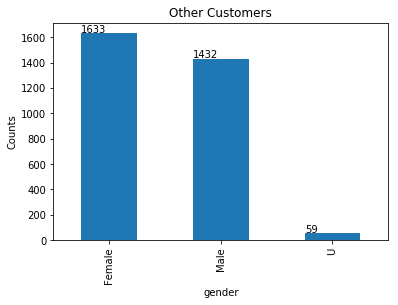

In [58]:
cat_barplot(other_customers, 'gender')
plt.title('Other Customers');

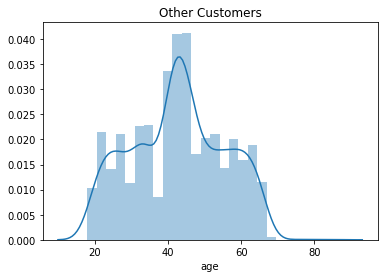

In [59]:
# check the age distribution of other customers
sns.distplot(other_customers['age'].dropna())
plt.title('Other Customers');

Text(0.5, 1.0, 'Other Customers')

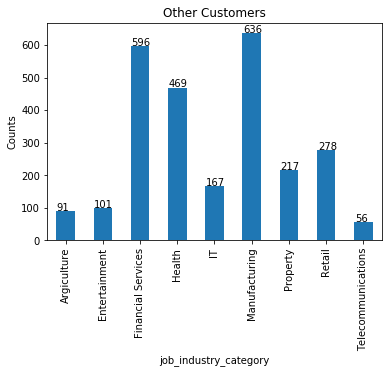

In [60]:
# job_industry_category condition in other customers
cat_barplot(other_customers, 'job_industry_category')
plt.title('Other Customers')

Text(0.5, 1.0, 'Other Customers')

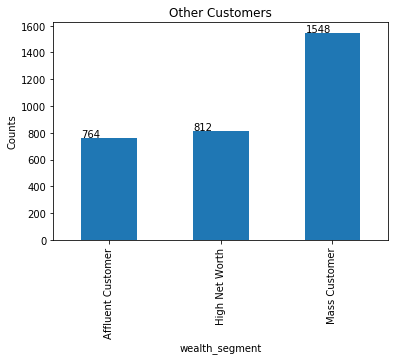

In [61]:
# wealth condition in other customers
cat_barplot(other_customers, 'wealth_segment')
plt.title('Other Customers')

In [62]:
# over all customers' wealth condition
customers.wealth_segment.value_counts()

Mass Customer        1997
High Net Worth       1020
Affluent Customer     978
Name: wealth_segment, dtype: int64

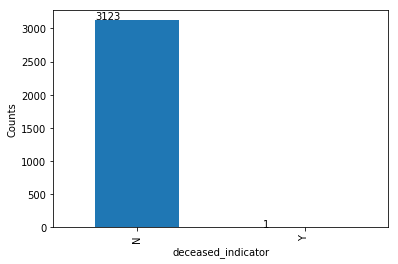

In [63]:
# deceased_indicator condition in other customers
cat_barplot(other_customers, 'deceased_indicator')

In [64]:
# check the overall customers's decreased indicator
customers.deceased_indicator.value_counts()

N    3993
Y       2
Name: deceased_indicator, dtype: int64

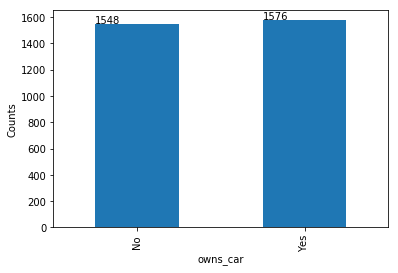

In [65]:
# car condition in other customers
cat_barplot(other_customers, 'owns_car')

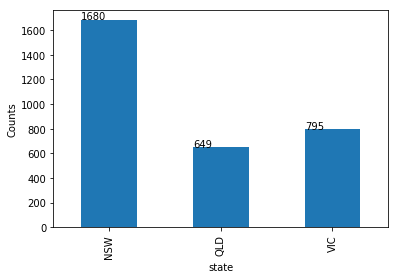

In [66]:
# where are these other customers
cat_barplot(other_customers, 'state')

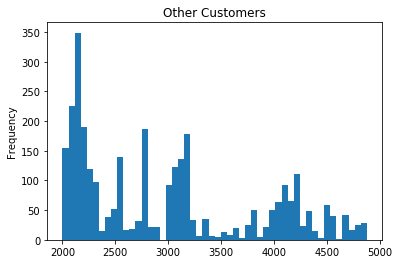

In [67]:
# postcode distribution
other_customers.postcode.plot(kind='hist', bins=50)
plt.title('Other Customers');

In [68]:
# overall customers state condition
customers.state.value_counts()

NSW    2138
VIC    1021
QLD     836
Name: state, dtype: int64

In [69]:
other_customers.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,age
count,3124.000000,3124.000000,3065.000000,3124.000000,3124.000000,3065.000000
mean,2070.247439,48.449104,10.563785,2980.350192,7.532330,42.688418
std,1184.179792,28.795874,5.640439,843.503700,2.824107,12.639398
min,1.000000,0.000000,1.000000,2000.000000,1.000000,18.000000
25%,1039.500000,23.000000,6.000000,2196.000000,6.000000,33.000000
50%,2077.500000,48.000000,10.000000,2768.000000,8.000000,43.000000
75%,3130.250000,73.000000,15.000000,3747.500000,10.000000,52.000000
max,4000.000000,99.000000,22.000000,4879.000000,12.000000,85.000000


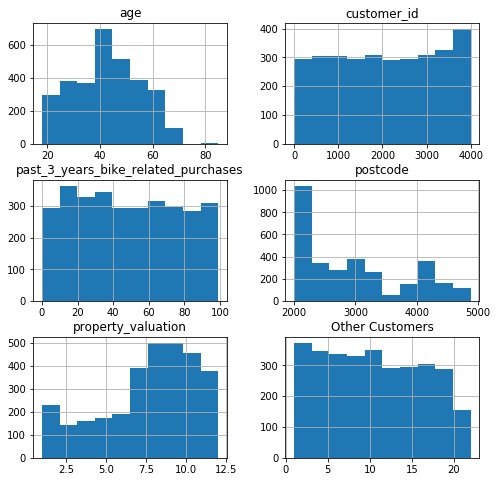

In [70]:
# the distribution of each feature in the other customer
other_customers.hist(figsize=(8,8))
plt.title('Other Customers');

In [71]:
# Bin edges that will be used to "cut" the age into groups
bin_edges = [0,21,31,41,51,61,110]
# Labels for the four popularity groups
bin_names = ['0-20','21-30','31-40','41-50','51-60', '>60']
# Creates popuar levels column
other_customers['age_levels'] = pd.cut(other_customers['age'], bin_edges, labels=bin_names, right=False)
# Checks for successful creation of this column
other_customers.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,age,age_levels
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,NSW,10,66.0,>60
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,NSW,10,39.0,31-40
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,0 Holy Cross Court,4211,QLD,9,58.0,51-60
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,NSW,4,43.0,41-50
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,VIC,9,54.0,51-60


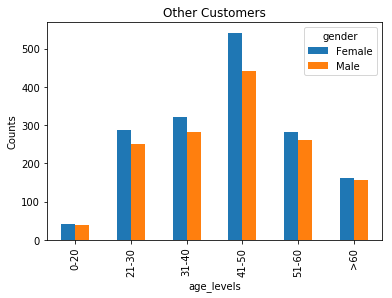

In [72]:
# Find the gender condition in each age level
other_customers.groupby(['age_levels','gender']).size().unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Counts');

Female are more than male in each age level of other customers.

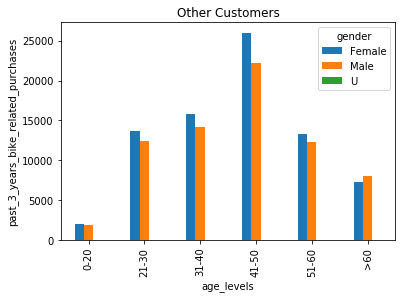

In [73]:
# Find the past_3_years_bike_related_purchases with groupby age level and gender
other_customers.groupby(['age_levels','gender']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('past_3_years_bike_related_purchases');

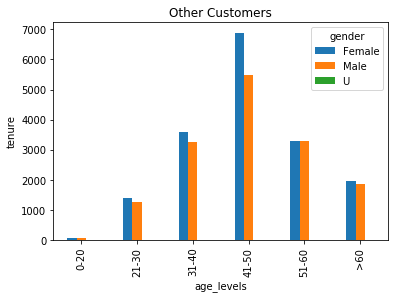

In [74]:
# Find the tenure with groupby age level and gender
other_customers.groupby(['age_levels','gender']).sum()['tenure'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('tenure');

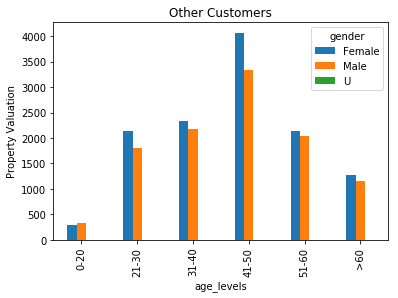

In [75]:
# Find the property_valuation with groupby age level and gender
other_customers.groupby(['age_levels','gender']).sum()['property_valuation'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Property Valuation');

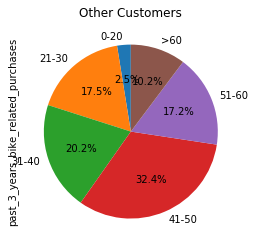

In [76]:
# past_3_years_bike_related_purchases in different age levels
other_customers.groupby(['age_levels']).sum()['past_3_years_bike_related_purchases'].plot(kind='pie', subplots=True,startangle=90, autopct='%1.1f%%')
plt.title('Other Customers');

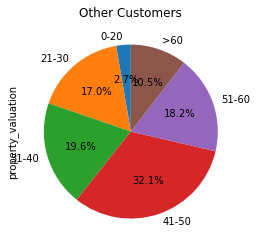

In [77]:
# property valuation in different age levels
other_customers.groupby(['age_levels']).sum()['property_valuation'].plot(kind='pie', subplots=True,startangle=90, autopct='%1.1f%%')
plt.title('Other Customers');

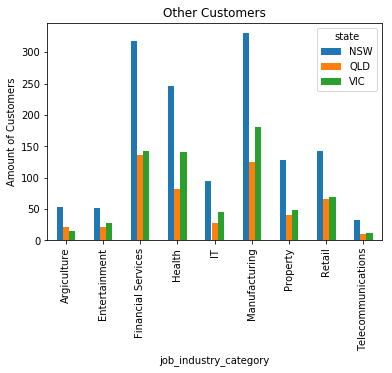

In [78]:
# job_industry_category in each state
other_customers.groupby(['job_industry_category','state']).size().unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Amount of Customers');

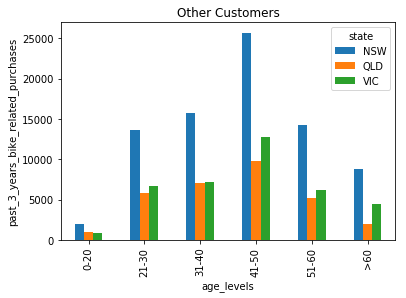

In [79]:
# past_3_years_bike_related_purchases in different age levels and states
other_customers.groupby(['age_levels','state']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('past_3_years_bike_related_purchases');

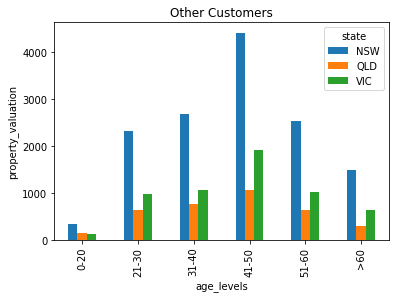

In [80]:
# property_valuation in different age levels and states
other_customers.groupby(['age_levels','state']).sum()['property_valuation'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('property_valuation');

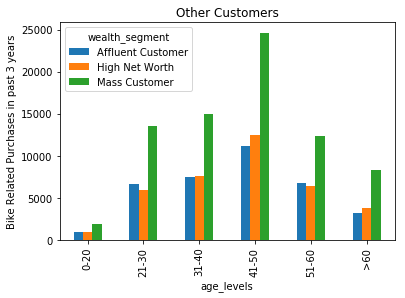

In [81]:
# purchases condition in different age levels and wealth conditions
other_customers.groupby(['age_levels', 'wealth_segment']).sum()['past_3_years_bike_related_purchases'].unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Bike Related Purchases in past 3 years');

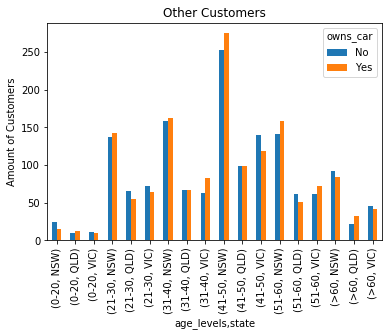

In [82]:
# car owning condition in different age levels and state
other_customers.groupby(['age_levels','state','owns_car']).size().unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Amount of Customers');

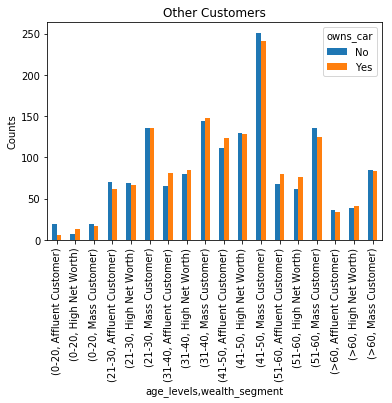

In [83]:
#  car owning condition in different age levels and wealth conditions
other_customers.groupby(['age_levels','wealth_segment','owns_car']).size().unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Counts');

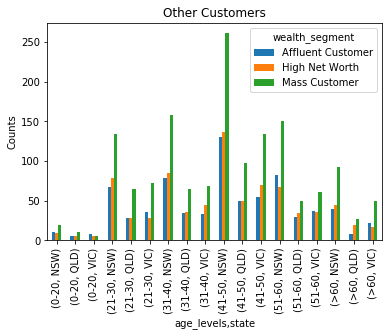

In [84]:
# wealth condition in different age levels and states
other_customers.groupby(['age_levels','state', 'wealth_segment']).size().unstack().plot(kind='bar')
plt.title('Other Customers')
plt.ylabel('Counts');

In [85]:
# create a new dataframe for correlation map, it will ignore the nan values
corr_other = other_customers[['gender', 'past_3_years_bike_related_purchases','wealth_segment', 'owns_car', 'state','property_valuation', 'age_levels']]
corr_other_dummy = pd.get_dummies(corr_other.copy())
corr_other_dummy.head()

,past_3_years_bike_related_purchases,property_valuation,gender_Female,gender_Male,gender_U,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,owns_car_No,owns_car_Yes,state_NSW,state_QLD,state_VIC,age_levels_0-20,age_levels_21-30,age_levels_31-40,age_levels_41-50,age_levels_51-60,age_levels_>60
0,93,10,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1
1,81,10,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0
2,33,9,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0
3,56,4,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
4,35,9,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Text(158.09375, 0.5, '')

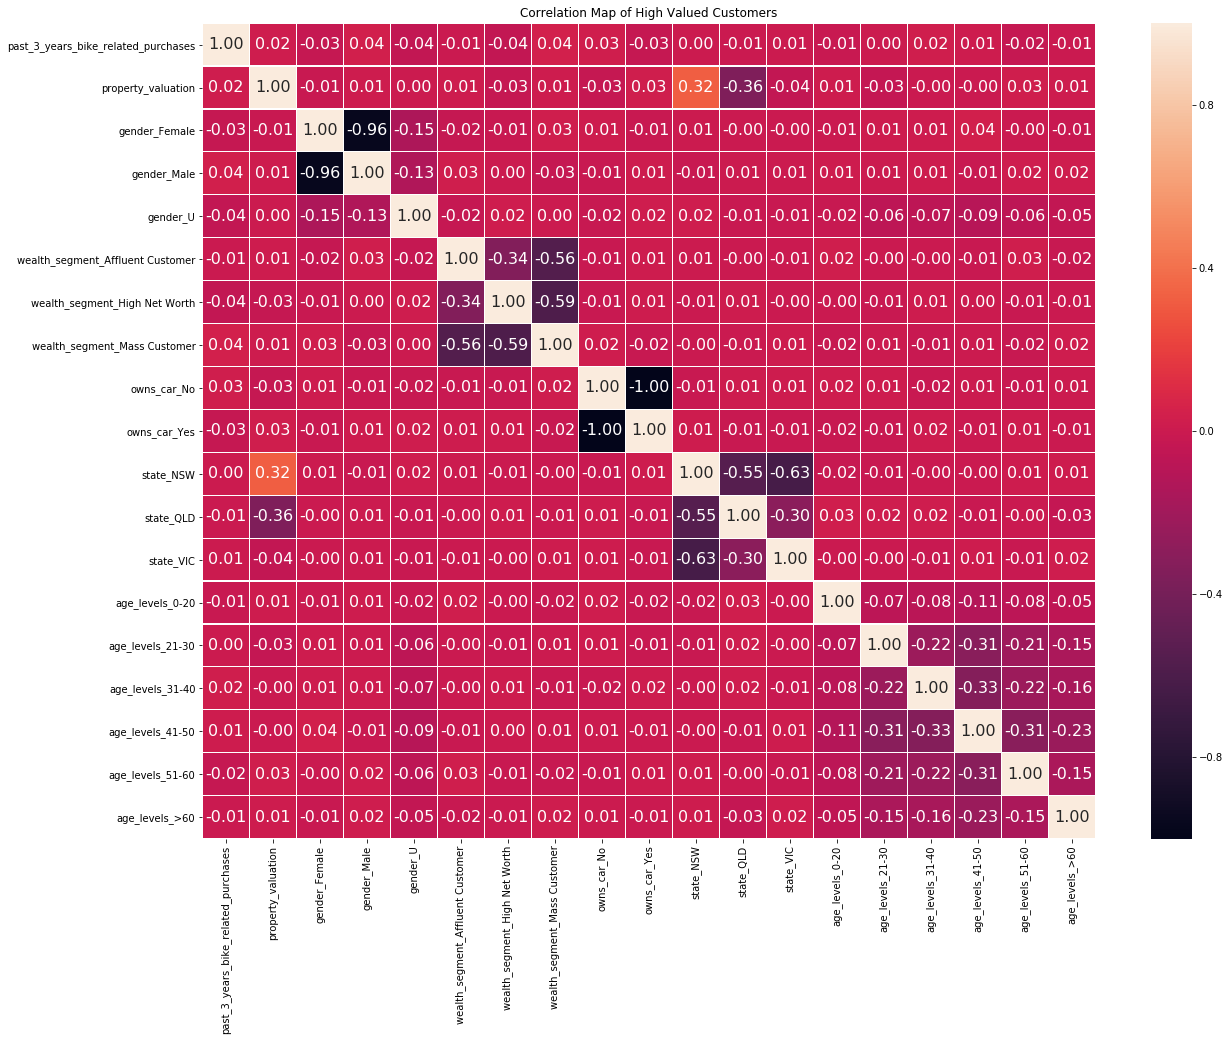

In [86]:
# the correlation map of each variable
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title('Correlation Map of High Valued Customers')

sns.heatmap(corr_other_dummy.corr(),
            xticklabels=corr_other_dummy.columns.values,
            yticklabels=corr_other_dummy.columns.values,
            annot = True,
            annot_kws={"size": 16},
            linewidths=0.2,
            fmt=".2f",);
plt.xlabel('') 
plt.ylabel('')

# Predict High Valued Customers in New Customers List by ML Models

### 1. Prepare the data

In [23]:
# add target label column high value, 1 for high valued customers
customers['high_valued_customer'] = customers.apply(lambda x: 1 if x['customer_id'] in high_value_customer_id else 0, axis=1)
customers['high_valued_customer'].value_counts()

0    3124
1     871
Name: high_valued_customer, dtype: int64

**The data in high_valued_customer column is imbalanced, which will completely ignoring the minority class in favor of the majority class in later machine learning modeling**.   

#### Up-sample Minority Class

In [24]:
# Separate majority and minority classes 
majority = customers[customers.high_valued_customer==0]
minority = customers[customers.high_valued_customer==1]
 
# Upsample minority class
customers_minority_upsampled = resample(minority, 
                             replace=True,     # sample with replacement
                             n_samples=3124,    # to match majority class
                             random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
customers_upsampled = pd.concat([majority, customers_minority_upsampled])
 
# Display new class counts
customers_upsampled.high_valued_customer.value_counts()

1    3124
0    3124
Name: high_valued_customer, dtype: int64

In [25]:
# Split the data into features and target label
target = customers_upsampled['high_valued_customer']
feature = customers_upsampled[['gender','past_3_years_bike_related_purchases','DOB','job_industry_category','wealth_segment','tenure','state','property_valuation']]

In [26]:
# prepare the feature data before the ML model training
# convert the DOB into age
feature['age'] = feature['DOB'].apply(lambda x: from_dob_to_age(x))
feature.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,tenure,state,property_valuation,age
0,Female,93,1953-10-12,Health,Mass Customer,11.0,NSW,10,66.0
1,Male,81,1980-12-16,Financial Services,Mass Customer,16.0,NSW,10,39.0
2,Male,33,1961-10-03,IT,Mass Customer,7.0,QLD,9,58.0
3,Female,56,1977-05-13,NaN,Affluent Customer,8.0,NSW,4,43.0
4,Male,35,1966-09-16,Retail,High Net Worth,13.0,VIC,9,54.0


In [27]:
# drop the DOB column
feature = feature.drop('DOB', axis=1)
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6248 entries, 0 to 1104
Data columns (total 8 columns):
gender                                 6248 non-null object
past_3_years_bike_related_purchases    6248 non-null int64
job_industry_category                  5227 non-null object
wealth_segment                         6248 non-null object
tenure                                 6090 non-null float64
state                                  6248 non-null object
property_valuation                     6248 non-null int64
age                                    6090 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 439.3+ KB


In [28]:
# fill the missing values in tenure and age with the median of values in each column
feature['tenure'] = feature['tenure'].fillna(feature['tenure'].median()).astype('int')
feature['age'] = feature['age'].fillna(feature['age'].median()).astype('int')
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6248 entries, 0 to 1104
Data columns (total 8 columns):
gender                                 6248 non-null object
past_3_years_bike_related_purchases    6248 non-null int64
job_industry_category                  5227 non-null object
wealth_segment                         6248 non-null object
tenure                                 6248 non-null int64
state                                  6248 non-null object
property_valuation                     6248 non-null int64
age                                    6248 non-null int64
dtypes: int64(4), object(4)
memory usage: 439.3+ KB


In [29]:
# fill the missing values in job_industry_category with M, which will treat missing data as just another category
# the missing values in job_industry_category is around 16%. If we simply drop them, it will lose the variance of the other feature in this small dataset
feature['job_industry_category'] = feature['job_industry_category'].fillna('M')
feature.isnull().sum()

gender                                 0
past_3_years_bike_related_purchases    0
job_industry_category                  0
wealth_segment                         0
tenure                                 0
state                                  0
property_valuation                     0
age                                    0
dtype: int64

In [30]:
# Normalizing Numerical Features
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['past_3_years_bike_related_purchases', 'tenure', 'property_valuation', 'age']

feature_minmax_transform = pd.DataFrame(data = feature)
feature_minmax_transform[numerical] = scaler.fit_transform(feature_minmax_transform[numerical])

# Show an example of a record with scaling applied
feature_minmax_transform.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,tenure,state,property_valuation,age
0,Female,0.939394,Health,Mass Customer,0.476190,NSW,0.818182,0.685714
1,Male,0.818182,Financial Services,Mass Customer,0.714286,NSW,0.818182,0.300000
2,Male,0.333333,IT,Mass Customer,0.285714,QLD,0.727273,0.571429
3,Female,0.565657,M,Affluent Customer,0.333333,NSW,0.272727,0.357143
4,Male,0.353535,Retail,High Net Worth,0.571429,VIC,0.727273,0.514286


In [31]:
# convert categorical variables is by using the one-hot encoding scheme
features_final = pd.get_dummies(feature_minmax_transform)
# Print the number of features after one-hot encoding
print("{} total features after one-hot encoding.".format(len(list(features_final.columns))))

23 total features after one-hot encoding.


**Shuffle and Split Data**   
- we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for validation testing.

In [32]:
# Split the 'feature' and 'target' data into training and validation testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print('Training set has {} samples.'.format(X_train.shape[0]))
print('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 4998 samples.
Testing set has 1250 samples.


### 2. Machine Learning Model Implementation
**Random Forset**
- Random forest model can be applied in entertainment, e-commerce, mobile apps, education, etc. as the [Recommendation Engine](https://www.newgenapps.com/blog/random-forest-analysis-in-ml-and-when-to-use-it/), which analyzes the user behavior to suggest items which they are likely to prefer.For instance, the suggestions based on mutual friends and connections in [Facebook and Linkedin](https://www.newgenapps.com/blog/what-is-recommendation-engine-uses-personalization/).
- [Strengths](https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706) - Random forests is great with high dimensional data since we are working with subsets of data, can be run in parallel to speed up training, reduces variance caused by decision trees by combining multiple decision trees, handles outliers by essentially binning them and it is also indifferent to non-linear features and has methods for balancing error in class population unbalanced data sets.
- Weaknesses - Random forest models are not all that interpretable; they are like black boxes, the size of the trees can take up a lot of memory for very large data sets, It can tend to overfit, so you should tune the hyperparameters.
- Candidacy - random forest gives good performance when there are categorical variables. As there are around 3995 entries, random forest can train much better.

In [33]:
# Initialize model
clf = RandomForestClassifier(random_state=42)

# fit the model with training data 
clf.fit(X_train, y_train)
# get the predictions on the test set(X_test)
prediction = clf.predict(X_test)

#### Initial Model Evaluation

In [34]:
# compute accuracy and F score on validation test set, since we want to minimize false negative
print('Accuracy of Random Forest model is {}.'.format(accuracy_score(y_test,prediction)))
print('F-score of Random Forest model is {}.'.format(fbeta_score(y_test, prediction, beta=2)))

Accuracy of Random Forest model is 0.9272.
F-score of Random Forest model is 0.9440894568690097.


In [35]:
np.unique(prediction, return_counts=True)

(array([0, 1]), array([596, 654]))

**Logistic Regression**
- Logistic Regression is the go-to method for binary classification. It gives you a discrete binary outcome between 0 and 1. To say it in simpler words, it’s outcome is either one thing or another. [A marketing consultant wants to predict if the subsidiary of his company will make profit, loss or just break even depending on the characteristic of the subsidiary operations](https://www.analyticsinsight.net/introduction-to-logistic-regression/) and in medical area, it would used be an [cancer detection](https://machinelearning-blog.com/2018/04/23/logistic-regression-101/) that takes screening picture as an input and should tell if a patient has cancer (1) or not (0).
- [Strengths](https://towardsdatascience.com/real-world-implementation-of-logistic-regression-5136cefb8125) - It is a widely used technique because it is very efficient, does not require too many computational resources, it’s highly interpretable, it doesn’t require input features to be scaled, it doesn’t require any tuning, it’s easy to regularize, and it outputs well-calibrated predicted probabilities.
- [Weaknesses](https://machinelearning-blog.com/2018/04/23/logistic-regression-101/) - Logistic Regression is also not one of the most powerful algorithms out there and can be easily outperformed by more complex ones. Also, we can’t solve non-linear problems with logistic regression since it’s decision surface is linear. Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.
- Candidacy - problem is of binary classification with clean data, all favourable conditions for logistic regression.

In [36]:
# Initialize model
clf_lg = LogisticRegression(random_state=42)

# fit the model with training data 
clf_lg.fit(X_train, y_train)
# get the predictions on the test set(X_test)
prediction_lg = clf_lg.predict(X_test)

#### Initial Model Evaluation

In [37]:
# compute accuracy and F score on validation test set, since we want to minimize false negative
print('Accuracy of Logistic Regression model is {}.'.format(accuracy_score(y_test,prediction_lg)))
print('F-score of Logistic Regression model is {}.'.format(fbeta_score(y_test, prediction_lg, beta=2)))

Accuracy of Logistic Regression model is 0.524.
F-score of Logistic Regression model is 0.517464424320828.


In [38]:
np.unique(prediction_lg, return_counts=True)

(array([0, 1]), array([634, 616]))

#### Compared to Logistic Regression model, Random Forset model has high accuracy(0.92) and F score(0.94). We finally choose Random Forset model as our high valued customers recommendation model.

### Prepare new customer list data for prediction

In [103]:
# import the NewCustomerList and skip the first row which is note
new_customer_list = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='NewCustomerList', skiprows=1)
new_customer_list.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.75,0.7500,0.9375,0.796875,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,0.65,0.6500,0.6500,0.650000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.83,1.0375,1.0375,1.037500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.96,0.9600,1.2000,1.200000,4,4,1.703125


In [104]:
# Drop Unnamed Columns which are not there in original table
cols = ['Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20']
new_customer_list = new_customer_list.drop(cols, axis=1)
new_customer_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
first_name                             1000 non-null object
last_name                              971 non-null object
gender                                 1000 non-null object
past_3_years_bike_related_purchases    1000 non-null int64
DOB                                    983 non-null datetime64[ns]
job_title                              894 non-null object
job_industry_category                  835 non-null object
wealth_segment                         1000 non-null object
deceased_indicator                     1000 non-null object
owns_car                               1000 non-null object
tenure                                 1000 non-null int64
address                                1000 non-null object
postcode                               1000 non-null int64
state                                  1000 non-null object
country                                1000 non-null 

In [105]:
# Split the data into features, which is the same feature as the above
feature_new_customers = new_customer_list[['gender','past_3_years_bike_related_purchases','DOB','job_industry_category','wealth_segment','tenure','state','property_valuation']]
feature_new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                                 1000 non-null object
past_3_years_bike_related_purchases    1000 non-null int64
DOB                                    983 non-null datetime64[ns]
job_industry_category                  835 non-null object
wealth_segment                         1000 non-null object
tenure                                 1000 non-null int64
state                                  1000 non-null object
property_valuation                     1000 non-null int64
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 62.6+ KB


In [106]:
# convert the DOB into age
feature_new_customers['age'] = feature_new_customers['DOB'].apply(lambda x: from_dob_to_age(x))
feature_new_customers.head()

/home/reina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,tenure,state,property_valuation,age
0,Male,86,1957-07-12,Manufacturing,Mass Customer,14,QLD,6,63.0
1,Male,69,1970-03-22,Property,Mass Customer,16,NSW,11,50.0
2,Female,10,1974-08-28,Financial Services,Affluent Customer,10,VIC,5,46.0
3,Female,64,1979-01-28,Manufacturing,Affluent Customer,5,QLD,1,41.0
4,Female,34,1965-09-21,Financial Services,Affluent Customer,19,NSW,9,55.0


In [107]:
# drop the DOB column
feature_new_customers = feature_new_customers.drop('DOB', axis=1)
feature_new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                                 1000 non-null object
past_3_years_bike_related_purchases    1000 non-null int64
job_industry_category                  835 non-null object
wealth_segment                         1000 non-null object
tenure                                 1000 non-null int64
state                                  1000 non-null object
property_valuation                     1000 non-null int64
age                                    983 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 62.6+ KB


In [108]:
# fill the missing values in tenure and age with the median of values in each column
# use the age median in training dataset to replace the missing values, which keeps the consistency of the trained model
feature_new_customers['age'] = feature_new_customers['age'].fillna(feature['age'].median()).astype('int')

# fill the missing values in job_industry_category with M, which ensures the consistency of the trained model
feature_new_customers['job_industry_category'] = feature_new_customers['job_industry_category'].fillna('M')
feature_new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                                 1000 non-null object
past_3_years_bike_related_purchases    1000 non-null int64
job_industry_category                  1000 non-null object
wealth_segment                         1000 non-null object
tenure                                 1000 non-null int64
state                                  1000 non-null object
property_valuation                     1000 non-null int64
age                                    1000 non-null int64
dtypes: int64(4), object(4)
memory usage: 62.6+ KB


#### Normalizing Numerical Features

In [109]:
# use the same scaler to transform the numerical data
feature_nc_transform = pd.DataFrame(data = feature_new_customers)
feature_nc_transform[numerical] = scaler.transform(feature_nc_transform[numerical])

# Show an example of a record with scaling applied
feature_nc_transform.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,tenure,state,property_valuation,age
0,Male,0.868687,Manufacturing,Mass Customer,0.619048,QLD,0.454545,0.642857
1,Male,0.696970,Property,Mass Customer,0.714286,NSW,0.909091,0.457143
2,Female,0.101010,Financial Services,Affluent Customer,0.428571,VIC,0.363636,0.400000
3,Female,0.646465,Manufacturing,Affluent Customer,0.190476,QLD,0.000000,0.328571
4,Female,0.343434,Financial Services,Affluent Customer,0.857143,NSW,0.727273,0.528571


In [110]:
# convert categorical variables is by using the one-hot encoding scheme
features_nc_final = pd.get_dummies(feature_nc_transform)
# Print the number of features after one-hot encoding
print("{} total features after one-hot encoding.".format(len(list(features_nc_final.columns))))

23 total features after one-hot encoding.


#### Predict High Valued Customers in New Customers

In [111]:
# get the predictions on the features of new customer by using the trained random forest model
prediction_nc = clf.predict(features_nc_final)
type(prediction_nc)

numpy.ndarray

In [112]:
# show prediction results
np.unique(prediction_nc, return_counts=True)

(array([0, 1]), array([884, 116]))

In [113]:
# filter out high valued customers in new customer list 
nc_high_valued = new_customer_list[prediction_nc == 1]
nc_high_valued.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,1,1.718750
5,Druci,Brandli,Female,39,1951-04-29,Assistant Media Planner,Entertainment,High Net Worth,N,Yes,22,89105 Pearson Terrace,4075,QLD,Australia,7,6,1.671875
9,Barthel,Docket,Male,72,1985-08-02,Accounting Assistant IV,IT,Mass Customer,N,Yes,17,80 Scofield Junction,4151,QLD,Australia,5,10,1.640625
19,Karly,Willavize,Female,2,1954-08-12,Internal Auditor,Manufacturing,High Net Worth,N,No,12,193 North Point,2190,NSW,Australia,10,19,1.531250
20,Teddie,Burchill,Male,11,1968-12-21,Programmer I,Manufacturing,Mass Customer,N,Yes,13,321 Raven Plaza,2161,NSW,Australia,9,21,1.515625


# Understand the Model
## 1. Feature Importance

[Text(0, 0, 'past_3_years_bike_related_purchases'),
 Text(0, 0, 'tenure'),
 Text(0, 0, 'property_valuation'),
 Text(0, 0, 'age'),
 Text(0, 0, 'gender_Female'),
 Text(0, 0, 'gender_Male'),
 Text(0, 0, 'gender_U'),
 Text(0, 0, 'job_industry_category_Argiculture'),
 Text(0, 0, 'job_industry_category_Entertainment'),
 Text(0, 0, 'job_industry_category_Financial Services'),
 Text(0, 0, 'job_industry_category_Health'),
 Text(0, 0, 'job_industry_category_IT'),
 Text(0, 0, 'job_industry_category_M'),
 Text(0, 0, 'job_industry_category_Manufacturing'),
 Text(0, 0, 'job_industry_category_Property'),
 Text(0, 0, 'job_industry_category_Retail'),
 Text(0, 0, 'job_industry_category_Telecommunications'),
 Text(0, 0, 'wealth_segment_Affluent Customer'),
 Text(0, 0, 'wealth_segment_High Net Worth'),
 Text(0, 0, 'wealth_segment_Mass Customer'),
 Text(0, 0, 'state_NSW'),
 Text(0, 0, 'state_QLD'),
 Text(0, 0, 'state_VIC')]

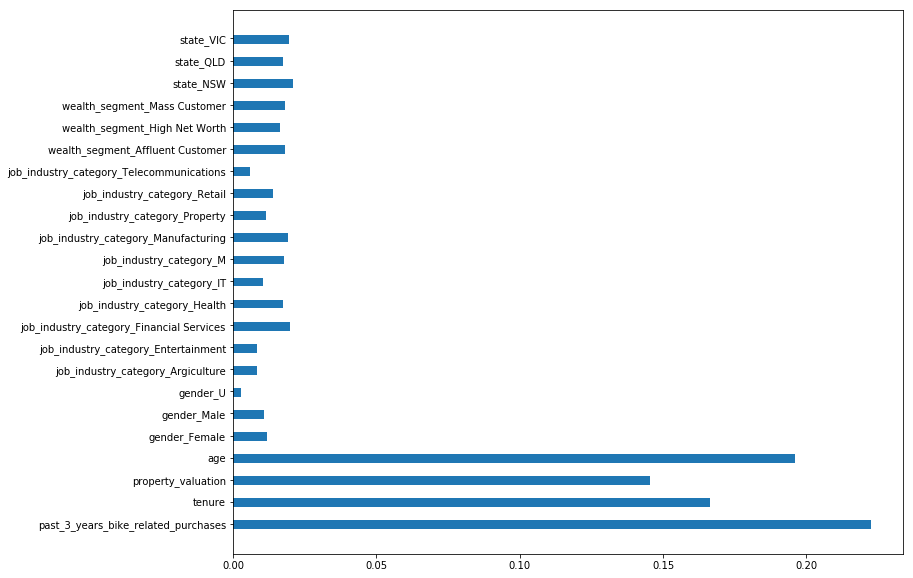

In [114]:
# extract feature importance
importances = clf.feature_importances_

# Plot
fig, ax = plt.subplots(figsize = (12, 10)) 
width = 0.4 # the width of the bars 
ind = np.arange(len(importances)) # the x locations for the groups
ax.barh(ind, importances, width)
ax.set_yticks(ind+width/10)
ax.set_yticklabels(X_train.columns, minor=False)

## 2. Tree Plot

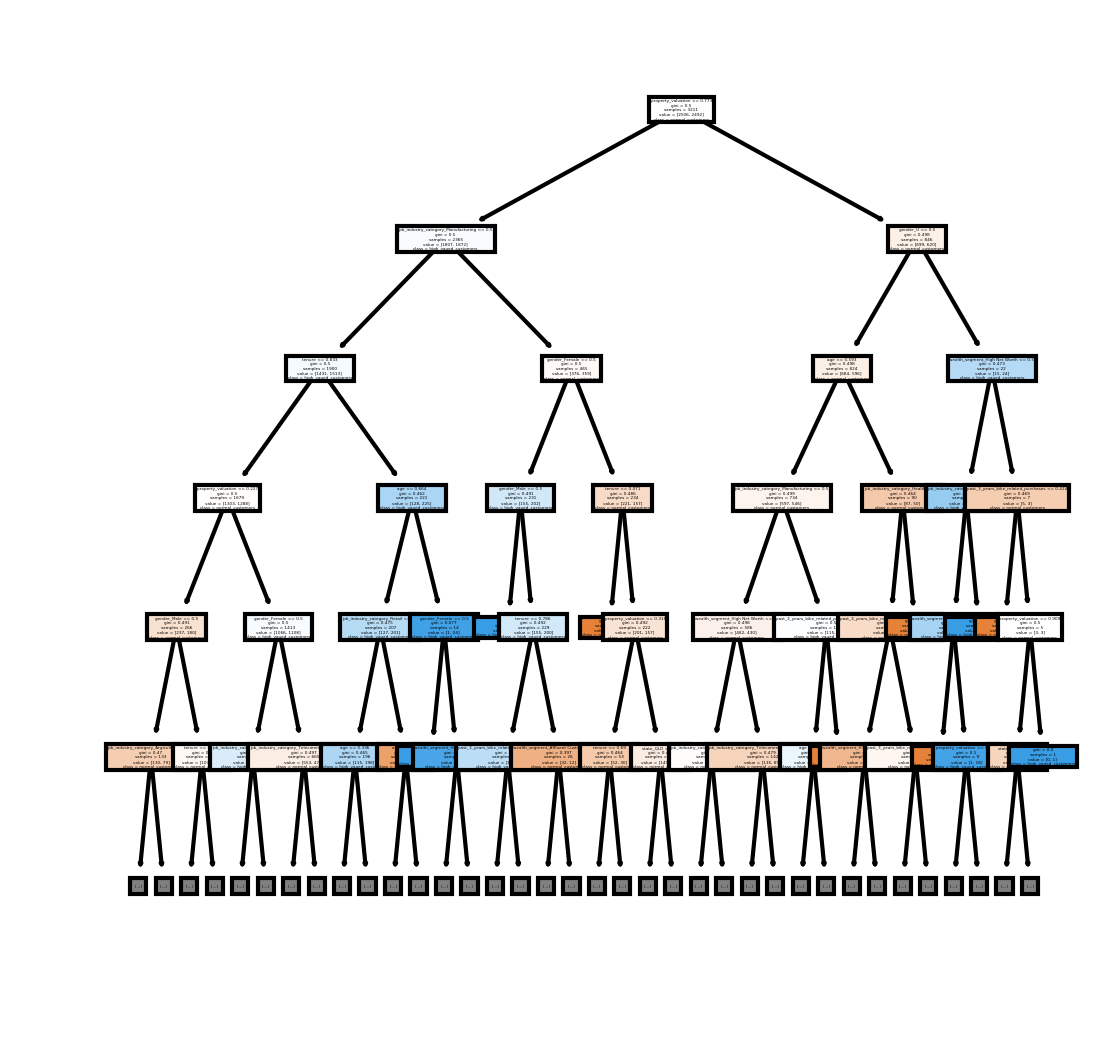

In [125]:
# https://www.codementor.io/@mgalarny/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-154mszcto7
estimator = clf.estimators_[5]
fig, axes = plt.subplots(figsize = (4,4), dpi=300)
tree.plot_tree(estimator,
                       max_depth = 5,
                       feature_names = X_train.columns, 
                       class_names=['normal_customers', 'high_vaued_customers'],
                       filled = True);
fig.savefig('RM_tree_high_valued_customers.png')